# Bayesian Inference of a Supermassive Black Hole Mass with JAM and AdaMet

[<img src="https://users.physics.ox.ac.uk/~cappellari/images/jam-logo.svg" width="100">](https://users.physics.ox.ac.uk/~cappellari/software/#sec:jam)

This notebook demonstrates how to measure the mass of a supermassive black hole in a galaxy using dynamical modeling.
The analysis uses the JAM method ([Cappellari 2008](https://ui.adsabs.harvard.edu/abs/2008MNRAS.390...71C/abstract), [Cappellari 2020](https://ui.adsabs.harvard.edu/abs/2020MNRAS.494.4819C/abstract)) as implemented in the [`jampy`](https://pypi.org/project/jampy/) package.
The Bayesian inference is performed with the AdaMet MCMC sampler ([Cappellari et al. 2013](https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C/abstract)) from the [`adamet`](https://pypi.org/project/adamet/) package.

- **V1.0.0**: Michele Cappellari, Oxford, 04 May 2018
- **V1.1.0**: Updated to use the new `jampy.jam_axi_proj`. MC, Oxford, 28 April 2021
- **V1.2.0**: Expanded documentation and converted to jupytext format. MC, Oxford, 21 July 2025

## 1. Imports

I begin by importing the necessary Python libraries. This includes standard data science packages like `numpy` for numerical operations and `matplotlib` for plotting. I also import specialized packages for astrophysical research:

- `plotbin`: A package for displaying binned kinematic data, which is a standard way to represent data from integral-field spectrographs.
- `jampy`: The core package for performing Jeans Anisotropic Modelling.
- `adamet`: An adaptive MCMC sampler that efficiently explores the parameter space to find the best-fitting model.

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# All packages below are available at https://pypi.org/user/micappe/
from plotbin.plot_velfield import plot_velfield
from plotbin.symmetrize_velfield import symmetrize_velfield

import capfit
import jampy as jam
from adamet.adamet import adamet
from adamet.corner_plot import corner_plot

## 2. MGE Model

To model the galaxy's dynamics, I first need an accurate description of its stellar light distribution, which I use as a proxy for the stellar mass distribution. I use a Multi-Gaussian Expansion (MGE), which models the observed surface brightness as a sum of co-centric 2D Gaussian functions. This method is particularly well-suited for JAM as it allows for an efficient calculation of the gravitational potential.

The MGE parameters used here describe the nearby galaxy M32 and are taken from Table B1 of [Cappellari et al. (2006)](http://adsabs.harvard.edu/abs/2006MNRAS.366.1126C).

- `surf`: The central surface brightness of each Gaussian component, in units of Lsun/pc^2.
- `sigma`: The dispersion (width) of each Gaussian, in arcseconds, which defines its size on the sky.
- `q_obs`: The observed axial ratio of each elliptical Gaussian component, describing its flattening.

In [2]:
surf = 10**np.array([6.187, 5.774, 5.766, 5.613, 5.311, 4.774, 4.359, 4.087, 3.682, 3.316, 2.744, 1.618])
sigma = 10**np.array([-1.762, -1.143, -0.839, -0.438, -0.104, 0.232, 0.560, 0.835, 1.160, 1.414, 1.703, 2.249])
q_obs = np.array([0.790, 0.741, 0.786, 0.757, 0.720, 0.724, 0.725, 0.743, 0.751, 0.838, 0.835, 0.720])

## 3. Mock Kinematics

In this example, I use simulated (mock) kinematic data rather than actual observations. This is a common and crucial step to test a modeling pipeline. By fitting a model to data with known ground-truth parameters, I can verify that our method can reliably recover those parameters.

The mock data file contains spatially binned kinematic information:

- `xbin`, `ybin`: The coordinates of the center of each spatial bin on the sky.
- `rms`: The root-mean-square velocity $V_{\rm rms} = \sqrt{V^2 + \sigma^2}$ of the stars in each bin, which is a measure of the second velocity moment.
- `erms`: The corresponding 1-sigma uncertainty on the $V_{\rm rms}$ values.
- `flux`: The total flux (surface brightness) in each bin.

I also define the `distance` to the galaxy in Megaparsecs, which is needed to convert angular sizes (in arcseconds) to physical sizes (in parsecs).

In [3]:
jam_dir = Path(jam.__file__).parent
filename = jam_dir / 'examples/jam_mock_kinematics_black_hole.txt'
xbin, ybin, rms, erms, flux = np.loadtxt(filename).T
distance = 0.7   # M32 Distance

## 4. Model Setup

Now I configure the JAM model. This involves defining the free parameters of the model and setting up the initial conditions for the fit.

### Assume mass follows light

A fundamental assumption in this initial model is that the total mass distribution is proportional to the light distribution. This implies a constant stellar mass-to-light ratio (M/L) within the region where I fit the kinematics. While this is a simplification (real galaxies can have varying M/L due to differences in stellar populations and dark matter), it is generally a very good approximation within the central regions. Under this assumption, the MGE that describes the surface brightness (`surf_lum`) also describes the surface mass density that generates the gravitational potential (`surf_pot`). The M/L ratio itself will be a free parameter in our fit.

In [4]:
surf_lum = surf_pot = surf
sigma_lum = sigma_pot = sigma
q_obs_lum = q_obs_pot = q_obs

### Starting guess (e.g., from a previous least-squares fit)

I need to provide an initial guess for the parameters I want to fit. A good starting point can significantly speed up the convergence of the MCMC sampler. These initial values are often obtained from a simpler, faster fitting method like least-squares, or from previous studies of the same galaxy.

The free parameters in our model are:

- `q0`: The intrinsic axial ratio of the galaxy (its 3D shape). This is the flattening of the galaxy if viewed edge-on.
- `bh0`: The mass of the supermassive black hole in solar masses.
- `lg_ml0`: The base-10 logarithm of the stellar mass-to-light ratio.
- `ratio0`: The velocity anisotropy ratio ($\beta_z = 1 - \sigma_z^2/\sigma_R^2$), which describes the shape of the stellar velocity ellipsoid. Anisotropy quantifies the flattening of the velocity ellipsoid.

> **Important:**  
> I use the axial ratio $q$ of the flattest MGE Gaussian to parametrize the inclination angle. This is the recommended approach in JAM because galaxy kinematics vary smoothly as a function of $q$, but not as a function of inclination. Parametrizing models by inclination can result in very inefficient sampling of the model posterior.

In [5]:
q0 = 0.4
bh0 = 2.5e6
lg_ml0 = np.log10(1.4)
ratio0 = 0.9    # anisotropy ratio sigma_z/sigma_R

### PSF: Typical Adaptive-Optics PSF (narrow core + broad wings)

When observing with a telescope, the light from a celestial object is blurred by the atmosphere and the instrument's optics. This effect is described by the Point Spread Function (PSF). Accurately modeling the PSF is critical, especially when studying the central regions of galaxies where the SBH's gravitational influence is dominant and sharp resolution is required. An inaccurate PSF can mimic or hide the kinematic signature of a black hole. Here, I use a two-component Gaussian model for the PSF, which is typical for observations with adaptive optics systems that provide a sharp core and broad "wings".

In [6]:
sigmapsf = [0.04, 0.4]  # sigma PSF in arcsec
normpsf = [0.7, 0.3]
pixsize = 0.05

### Priors: Starting parameters and bounds for the fit

In Bayesian inference, I must specify priors for our model parameters. A prior represents our belief about the parameter values before I have seen the data. I use uniform (or "flat") priors, which means I consider all values within a certain range (`bounds`) to be equally likely. This is a common choice when I don't have strong prior information.

- `p0`: A vector containing the initial guesses for the parameters.
- `bounds`: A list specifying the lower and upper bounds for each parameter. This defines the parameter space that the MCMC sampler will explore.
- `labels`: A list of strings for labeling the parameters in plots.
- `goodbins`: A boolean mask to select the kinematic bins that will be included in the fit (e.g., to exclude bins with low signal-to-noise).

In [ ]:
qmin = np.min(q_obs)
p0 =      [q0,    ratio0, bh0,     lg_ml0]
bounds = [[0.051, 0.5,    bh0/1.3, lg_ml0-0.04],
          [qmin,  1.5,    bh0*1.3, lg_ml0+0.04]]
labels = [r"$q_{\rm min}$", r"$\sigma_z/\sigma_R$", r"$M_{\rm BH}$", r"$\lg(M/L)_{\rm tot}$"]

goodbins = np.isfinite(xbin)  # Here I fit all bins

## 5. Bayesian Inference

### Define Log-Probability Function

The heart of our Bayesian analysis is the log-probability function, which in this case is the log-posterior. According to Bayes' theorem,

$$
P(\theta\,|\,\mathrm{data}) \propto P(\mathrm{data}\,|\,\theta)\,P(\theta)
$$

where $\theta$ are the model parameters. In logarithmic form,

$$
\log P(\theta\,|\,\mathrm{data}) = \log P(\mathrm{data}\,|\,\theta) + \log P(\theta)
$$

For flat priors, $\log P(\theta)$ is constant within the bounds and $-\infty$ outside. Therefore, within the bounds, the log-posterior is simply the log-likelihood plus a constant.

Assuming Gaussian measurement errors, the log-likelihood is

$$
\log P(\mathrm{data}\,|\,\theta) = -\frac{1}{2}\chi^2 + \text{costant}
$$

where

$$
\chi^2 = \sum_{i=1}^N \frac{[y_i - m_i(\theta)]^2}{\sigma_i^2}
$$

Here, $y_i$ are the observed data, $m_i(\theta)$ are the model predictions, and $\sigma_i$ are the measurement uncertainties.

The `jam.axi.proj` function takes the model parameters, computes the predicted kinematics, and compares them to the data to calculate $\chi^2$.

In [8]:
def jam_lnprob(pars):
    """Return the probability of the model, given the data, assuming constant priors"""

    q, ratio, mbh, lg_ml = pars
 
    # Sample inclination using min(q), with Equation (14) of Cappellari (2008)
    qmin = np.min(q_obs_lum)
    inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))
    beta = np.full_like(q_obs_lum, 1 - ratio**2)   # assume constant anisotropy

    # Note: surf_pot is multiplied by ml, while I set the keyword ml=1
    out = jam.axi.proj(surf_lum, sigma_lum, q_obs_lum, surf_pot*10**lg_ml, sigma_pot, q_obs_pot,
                    inc, mbh, distance, xbin, ybin, plot=False, pixsize=pixsize, quiet=1,
                    sigmapsf=sigmapsf, normpsf=normpsf, goodbins=goodbins, align='cyl',
                    beta=beta, data=rms, errors=erms, ml=1)

    jam_lnprob.out = out  # Store output for plotting

    resid = (rms[goodbins] - out.model[goodbins])/erms[goodbins]
    chi2 = resid @ resid

    return -0.5*chi2  # ln(likelihood) + cost.

### Run AdaMet MCMC

I now run the [AdaMet](https://pypi.org/project/adamet/) MCMC sampler which is the implementation by [Cappellari et al. (2013)](https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C/abstract) of the Adaptive Metropolis algorithm by [Haario et al. (2001)](https://scholar.google.co.uk/citations?view_op=view_citation&citation_for_view=p-y1OBgAAAAJ:u5HHmVD_uO8C). MCMC is a class of algorithms for sampling from a probability distribution. The sampler will perform a "random walk" through the parameter space, guided by the `jam_lnprob` function, to generate a chain of parameter values. The density of samples in different regions of the parameter space will be proportional to the posterior probability, meaning the chain will spend more time in regions of high probability.

For this demonstration, I use a small number of steps (`nstep`). For a scientific publication, a much larger number of steps would be necessary to ensure that the MCMC chain has converged to the true posterior distribution and is not just exploring a local maximum. The acceptance rate is an important diagnostic for the efficiency of the sampler; for a 4-dimensional problem like this one, the optimal rate is around 28%.

In [9]:
nstep = 1000
sigpar = np.array([0.1, 0.05, bh0*0.1, 0.01])  # crude estimate of uncertainties

print("Started AdaMet please wait...")
print("This example takes about 8 min on a 2GHz CPU")
print("Progress is printed roughly every minute")
pars, lnprob = adamet(jam_lnprob, p0, sigpar, bounds, nstep, plot=False,
                      nprint=nstep/10, labels=labels, seed=3)

Started AdaMet please wait...
This example takes about 8 min on a 2GHz CPU
Progress is printed roughly every minute
adamet: 10.0 done; 10.0 accepted
adamet: 20.0 done; 17.0 accepted
adamet: 30.0 done; 21.3 accepted
adamet: 40.0 done; 23.0 accepted
adamet: 50.0 done; 22.2 accepted
adamet: 60.0 done; 21.7 accepted
adamet: 70.0 done; 23.6 accepted
adamet: 80.0 done; 24.4 accepted
adamet: 90.0 done; 24.6 accepted
adamet: 100.0 done; 24.6 accepted
adamet: done. Total time 258.77 seconds


## 6. Results and Plots

### Extract Best Fit and Uncertainties

After the MCMC run is complete, I analyze the resulting chain of samples (`pars`) to determine the best-fitting parameter values and their uncertainties. The best-fit value for each parameter is taken as the one corresponding to the maximum log-probability found. The uncertainties are estimated from the width of the marginalized posterior distribution for each parameter. I quote the 1-sigma confidence interval (encompassing 68% of the probability), which I calculate from the 16th and 84th percentiles of the samples in the chain.

In [10]:
bestfit = pars[np.argmax(lnprob)]  # Best fitting parameters
perc = np.percentile(pars, [15.86, 84.14], axis=0)
sig_bestfit = np.squeeze(np.diff(perc, axis=0)/2)   # half of 68% interval

txt = capfit.format_values_with_errors(bestfit, sig_bestfit, labels)
print("\n" + txt.plain)


          q_min = 0.386 +/- 0.094
sigma_z/sigma_R = 0.968 +/- 0.068
           M_BH = (2.45 +/- 0.16)e6
    lg(M/L)_tot = 0.1454 +/- 0.0075


### Final Plot: Corner Plot and Model Comparison

Finally, I visualize the results of our MCMC analysis.

1.  **Corner Plot**: This is a standard and powerful way to visualize the results of an MCMC analysis. It shows the 1D marginalized posterior distribution for each parameter (as a histogram on the diagonal) and the 2D joint distributions for all pairs of parameters (as contour plots). This plot is extremely useful for understanding the parameter uncertainties and, crucially, any degeneracies (correlations) between them. For example, I can see if an increase in M/L can be compensated by a decrease in the black hole mass.
2.  **Data vs. Model**: I create a side-by-side comparison of the observed kinematics (the "data") and the kinematics predicted by the best-fitting JAM model. A good fit will show a close resemblance between the data and the model, with small, randomly-distributed residuals.

<Figure size 1043.2x782.4 with 0 Axes>

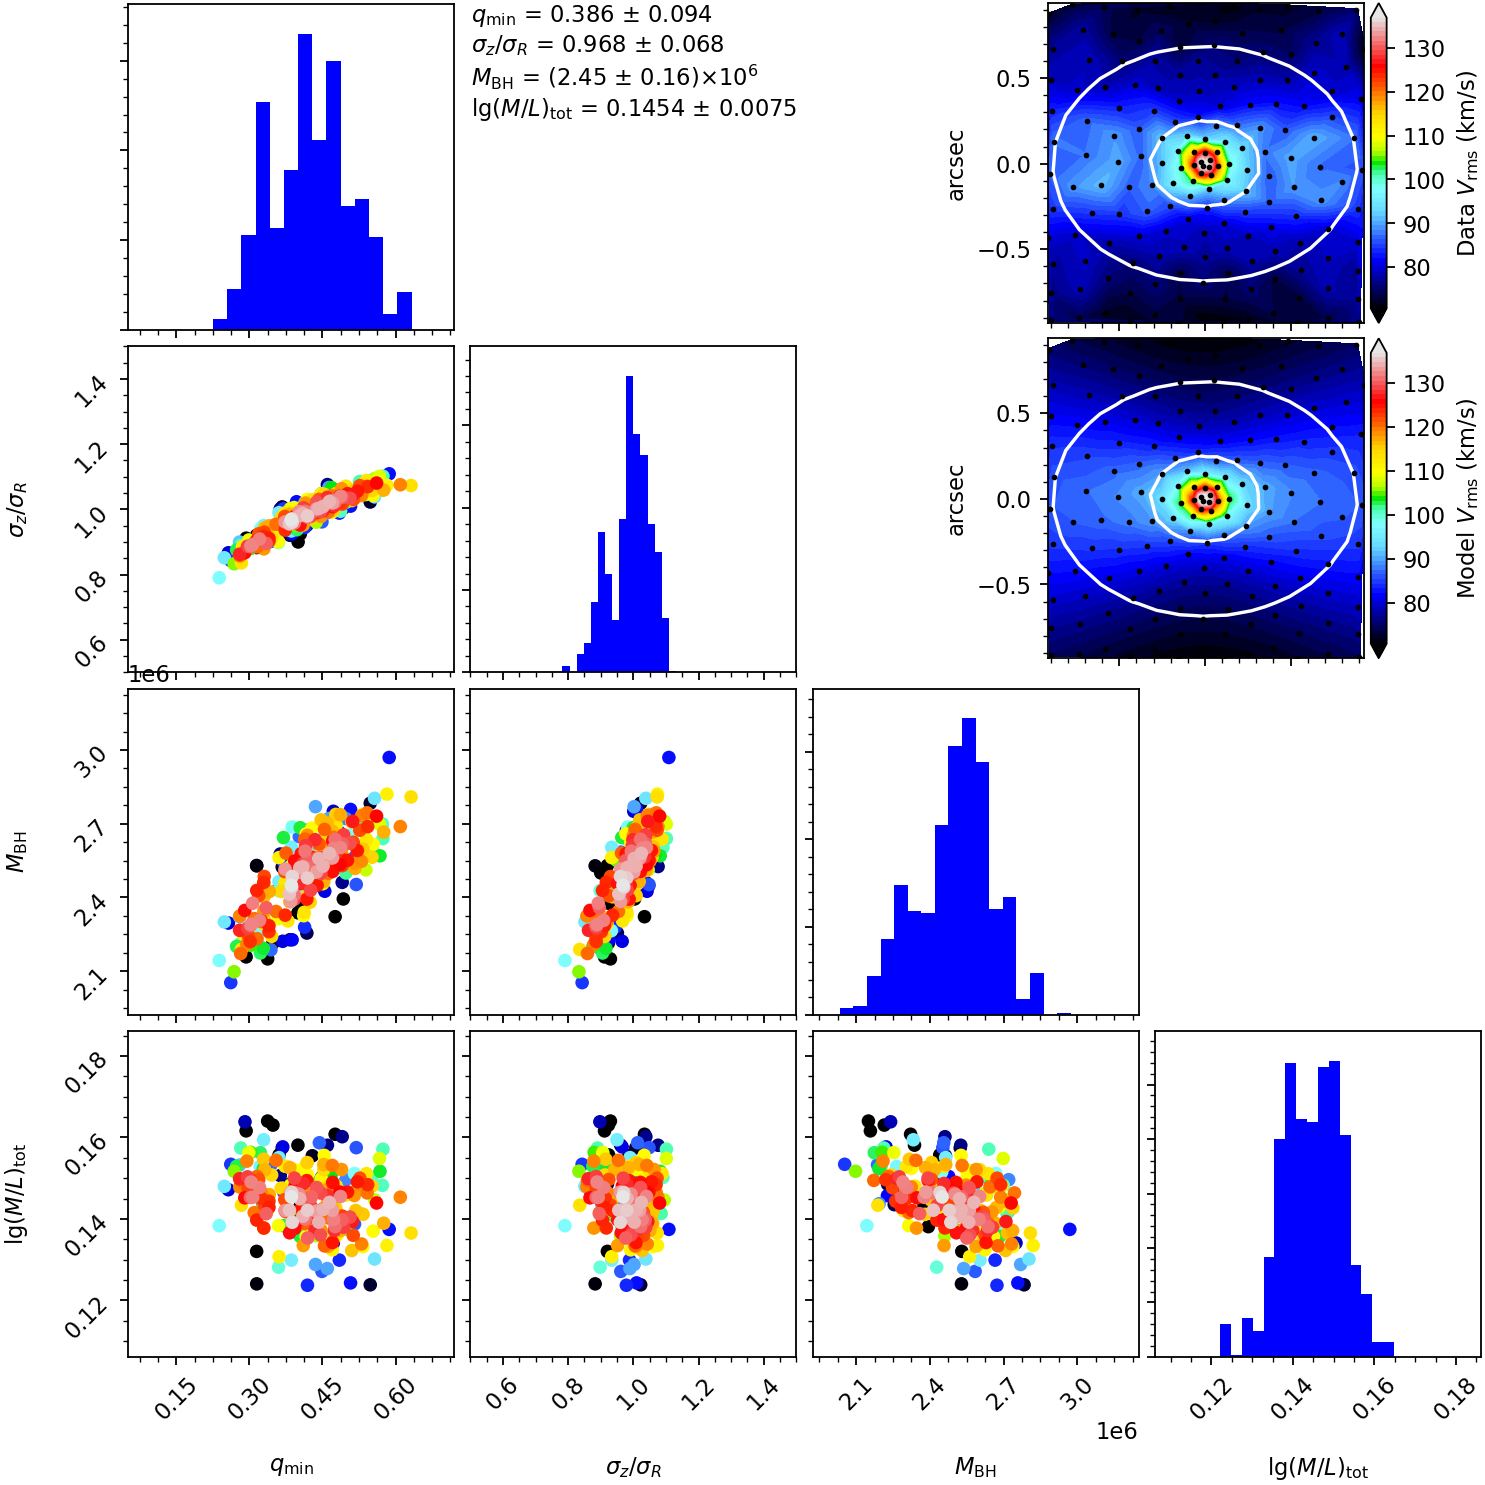

In [11]:
plt.clf()
fig = corner_plot(pars, lnprob, labels=labels, extents=bounds)
fig.text(0.33, .99, txt.latex, ha='left', va='top')
jam_lnprob(bestfit)  # Compute model at best fit location

dx = 0.24
yfac = 0.87

# Data
fig.add_axes([0.69, 0.99 - dx*yfac, dx, dx*yfac])  # left, bottom, xsize, ysize
rms1 = rms.copy()
rms1[goodbins] = symmetrize_velfield(xbin[goodbins], ybin[goodbins], rms[goodbins])
vmin, vmax = np.percentile(rms1[goodbins], [0.5, 99.5])
plot_velfield(xbin, ybin, rms1, vmin=vmin, vmax=vmax, linescolor='w',
                colorbar=1, label=r"Data $V_{\rm rms}$ (km/s)", flux=jam_lnprob.out.flux)
plt.tick_params(labelbottom=False)
plt.ylabel('arcsec')

# Model
fig.add_axes([0.69, 0.98 - 2*dx*yfac, dx, dx*yfac])  # left, bottom, xsize, ysize
plot_velfield(xbin, ybin, jam_lnprob.out.model, vmin=vmin, vmax=vmax, linescolor='w',
                colorbar=1, label=r"Model $V_{\rm rms}$ (km/s)", flux=jam_lnprob.out.flux)
plt.tick_params(labelbottom=False)
plt.ylabel('arcsec')
plt.show()